In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:cores",
    "device": "cuda",
    "lr": 0.0001,
    "labels": [
        "1-10.",
        "1-11.",
        "1-15.",
        "1-16.",
        "1-17.",
        "1-18.",
        "1-19.",
        "10-4.",
        "10-7.",
        "11-1.",
        "11-14.",
        "11-17.",
        "11-20.",
        "11-7.",
        "13-20.",
        "13-8.",
        "14-10.",
        "14-11.",
        "14-14.",
        "14-7.",
        "15-1.",
        "15-20.",
        "16-1.",
        "16-16.",
        "17-10.",
        "17-11.",
        "17-2.",
        "19-1.",
        "19-16.",
        "19-19.",
        "19-20.",
        "19-3.",
        "2-10.",
        "2-11.",
        "2-17.",
        "2-18.",
        "2-20.",
        "2-3.",
        "2-4.",
        "2-5.",
        "2-6.",
        "2-7.",
        "2-8.",
        "3-13.",
        "3-18.",
        "3-3.",
        "4-1.",
        "4-10.",
        "4-11.",
        "4-19.",
        "5-5.",
        "6-15.",
        "7-10.",
        "7-14.",
        "8-18.",
        "8-20.",
        "8-3.",
        "8-8.",
    ],
    "batch_size": 128,
    "domains_source": [1, 2, 3, 4, 5],
    "domains_target": [1, 2, 3, 4, 5],
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 58}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name_source": "cores.stratified_ds.2022A.pkl",
    "pickle_name_target": "cores.stratified_ds.2022A.pkl",
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1370], examples_per_second: 893.4350, train_label_loss: 3.9463, 


epoch: 1, [batch: 137 / 1370], examples_per_second: 11615.4026, train_label_loss: 1.7938, 


epoch: 1, [batch: 274 / 1370], examples_per_second: 11618.0825, train_label_loss: 0.8678, 


epoch: 1, [batch: 411 / 1370], examples_per_second: 11761.2421, train_label_loss: 0.3638, 


epoch: 1, [batch: 548 / 1370], examples_per_second: 11778.9038, train_label_loss: 0.2927, 


epoch: 1, [batch: 685 / 1370], examples_per_second: 11517.5318, train_label_loss: 0.2251, 


epoch: 1, [batch: 822 / 1370], examples_per_second: 11400.9308, train_label_loss: 0.1676, 


epoch: 1, [batch: 959 / 1370], examples_per_second: 11570.1607, train_label_loss: 0.1483, 


epoch: 1, [batch: 1096 / 1370], examples_per_second: 11590.1596, train_label_loss: 0.0624, 


epoch: 1, [batch: 1233 / 1370], examples_per_second: 11665.0281, train_label_loss: 0.0573, 


epoch: 1, source_val_acc_label: 0.9899, source_val_label_loss: 0.0759, target_val_acc_label: 0.9899, target_val_label_loss: 0.0759, 


New best
epoch: 2, [batch: 1 / 1370], examples_per_second: 57.4480, train_label_loss: 0.0319, 


epoch: 2, [batch: 137 / 1370], examples_per_second: 11659.2463, train_label_loss: 0.0392, 


epoch: 2, [batch: 274 / 1370], examples_per_second: 11609.2015, train_label_loss: 0.0620, 


epoch: 2, [batch: 411 / 1370], examples_per_second: 11598.1244, train_label_loss: 0.0440, 


epoch: 2, [batch: 548 / 1370], examples_per_second: 11640.7949, train_label_loss: 0.0194, 


epoch: 2, [batch: 685 / 1370], examples_per_second: 11589.1460, train_label_loss: 0.0190, 


epoch: 2, [batch: 822 / 1370], examples_per_second: 11709.0935, train_label_loss: 0.0199, 


epoch: 2, [batch: 959 / 1370], examples_per_second: 11746.1839, train_label_loss: 0.0123, 


epoch: 2, [batch: 1096 / 1370], examples_per_second: 11722.4777, train_label_loss: 0.0271, 


epoch: 2, [batch: 1233 / 1370], examples_per_second: 11565.3450, train_label_loss: 0.0195, 


epoch: 2, source_val_acc_label: 0.9934, source_val_label_loss: 0.0329, target_val_acc_label: 0.9934, target_val_label_loss: 0.0329, 


New best
epoch: 3, [batch: 1 / 1370], examples_per_second: 65.8681, train_label_loss: 0.0227, 


epoch: 3, [batch: 137 / 1370], examples_per_second: 11575.4649, train_label_loss: 0.0346, 


epoch: 3, [batch: 274 / 1370], examples_per_second: 11643.6144, train_label_loss: 0.0084, 


epoch: 3, [batch: 411 / 1370], examples_per_second: 11633.2719, train_label_loss: 0.0194, 


epoch: 3, [batch: 548 / 1370], examples_per_second: 11720.2100, train_label_loss: 0.0177, 


epoch: 3, [batch: 685 / 1370], examples_per_second: 11627.0928, train_label_loss: 0.0048, 


epoch: 3, [batch: 822 / 1370], examples_per_second: 11568.0225, train_label_loss: 0.0074, 


epoch: 3, [batch: 959 / 1370], examples_per_second: 11608.8753, train_label_loss: 0.0074, 


epoch: 3, [batch: 1096 / 1370], examples_per_second: 11593.3950, train_label_loss: 0.0092, 


epoch: 3, [batch: 1233 / 1370], examples_per_second: 11617.0053, train_label_loss: 0.0055, 


epoch: 3, source_val_acc_label: 0.9941, source_val_label_loss: 0.0255, target_val_acc_label: 0.9941, target_val_label_loss: 0.0255, 


New best
epoch: 4, [batch: 1 / 1370], examples_per_second: 65.3273, train_label_loss: 0.0087, 


epoch: 4, [batch: 137 / 1370], examples_per_second: 11597.5414, train_label_loss: 0.0031, 


epoch: 4, [batch: 274 / 1370], examples_per_second: 11679.1462, train_label_loss: 0.0034, 


epoch: 4, [batch: 411 / 1370], examples_per_second: 11608.3935, train_label_loss: 0.0032, 


epoch: 4, [batch: 548 / 1370], examples_per_second: 11677.3123, train_label_loss: 0.0026, 


epoch: 4, [batch: 685 / 1370], examples_per_second: 11522.9287, train_label_loss: 0.0047, 


epoch: 4, [batch: 822 / 1370], examples_per_second: 11551.7255, train_label_loss: 0.0259, 


epoch: 4, [batch: 959 / 1370], examples_per_second: 11464.6521, train_label_loss: 0.0051, 


epoch: 4, [batch: 1096 / 1370], examples_per_second: 11600.5920, train_label_loss: 0.0029, 


epoch: 4, [batch: 1233 / 1370], examples_per_second: 11858.3031, train_label_loss: 0.0022, 


epoch: 4, source_val_acc_label: 0.9971, source_val_label_loss: 0.0136, target_val_acc_label: 0.9971, target_val_label_loss: 0.0136, 


New best
epoch: 5, [batch: 1 / 1370], examples_per_second: 71.3432, train_label_loss: 0.0060, 


epoch: 5, [batch: 137 / 1370], examples_per_second: 12205.9706, train_label_loss: 0.0026, 


epoch: 5, [batch: 274 / 1370], examples_per_second: 12303.2934, train_label_loss: 0.0020, 


epoch: 5, [batch: 411 / 1370], examples_per_second: 12418.0457, train_label_loss: 0.0123, 


epoch: 5, [batch: 548 / 1370], examples_per_second: 12424.7018, train_label_loss: 0.0013, 


epoch: 5, [batch: 685 / 1370], examples_per_second: 12433.7545, train_label_loss: 0.0020, 


epoch: 5, [batch: 822 / 1370], examples_per_second: 11430.8059, train_label_loss: 0.0102, 


epoch: 5, [batch: 959 / 1370], examples_per_second: 10703.1276, train_label_loss: 0.0019, 


epoch: 5, [batch: 1096 / 1370], examples_per_second: 10754.7876, train_label_loss: 0.0023, 


epoch: 5, [batch: 1233 / 1370], examples_per_second: 10682.2107, train_label_loss: 0.0016, 


epoch: 5, source_val_acc_label: 0.9914, source_val_label_loss: 0.0307, target_val_acc_label: 0.9914, target_val_label_loss: 0.0307, 


epoch: 6, [batch: 1 / 1370], examples_per_second: 58.8902, train_label_loss: 0.0022, 


epoch: 6, [batch: 137 / 1370], examples_per_second: 10583.4309, train_label_loss: 0.0017, 


epoch: 6, [batch: 274 / 1370], examples_per_second: 10647.0551, train_label_loss: 0.0066, 


epoch: 6, [batch: 411 / 1370], examples_per_second: 10705.1325, train_label_loss: 0.0046, 


epoch: 6, [batch: 548 / 1370], examples_per_second: 10718.2240, train_label_loss: 0.0054, 


epoch: 6, [batch: 685 / 1370], examples_per_second: 10618.5709, train_label_loss: 0.0005, 


epoch: 6, [batch: 822 / 1370], examples_per_second: 10704.0684, train_label_loss: 0.0010, 


epoch: 6, [batch: 959 / 1370], examples_per_second: 10604.3606, train_label_loss: 0.0018, 


epoch: 6, [batch: 1096 / 1370], examples_per_second: 10707.0540, train_label_loss: 0.0042, 


epoch: 6, [batch: 1233 / 1370], examples_per_second: 10710.1737, train_label_loss: 0.0029, 


epoch: 6, source_val_acc_label: 0.9956, source_val_label_loss: 0.0176, target_val_acc_label: 0.9956, target_val_label_loss: 0.0176, 


epoch: 7, [batch: 1 / 1370], examples_per_second: 58.3802, train_label_loss: 0.0022, 


epoch: 7, [batch: 137 / 1370], examples_per_second: 10597.3416, train_label_loss: 0.0041, 


epoch: 7, [batch: 274 / 1370], examples_per_second: 10672.5184, train_label_loss: 0.0004, 


epoch: 7, [batch: 411 / 1370], examples_per_second: 10708.2324, train_label_loss: 0.0172, 


epoch: 7, [batch: 548 / 1370], examples_per_second: 10710.4716, train_label_loss: 0.0104, 


epoch: 7, [batch: 685 / 1370], examples_per_second: 10620.1117, train_label_loss: 0.0021, 


epoch: 7, [batch: 822 / 1370], examples_per_second: 10804.4325, train_label_loss: 0.0008, 


epoch: 7, [batch: 959 / 1370], examples_per_second: 10690.4878, train_label_loss: 0.0006, 


epoch: 7, [batch: 1096 / 1370], examples_per_second: 10726.1315, train_label_loss: 0.0107, 


epoch: 7, [batch: 1233 / 1370], examples_per_second: 10613.1652, train_label_loss: 0.0021, 


epoch: 7, source_val_acc_label: 0.9795, source_val_label_loss: 0.0696, target_val_acc_label: 0.9795, target_val_label_loss: 0.0696, 


epoch: 8, [batch: 1 / 1370], examples_per_second: 58.4274, train_label_loss: 0.0022, 


epoch: 8, [batch: 137 / 1370], examples_per_second: 10557.6097, train_label_loss: 0.0027, 


epoch: 8, [batch: 274 / 1370], examples_per_second: 10673.3609, train_label_loss: 0.0013, 


epoch: 8, [batch: 411 / 1370], examples_per_second: 10647.5806, train_label_loss: 0.0048, 


epoch: 8, [batch: 548 / 1370], examples_per_second: 10687.3205, train_label_loss: 0.0002, 


epoch: 8, [batch: 685 / 1370], examples_per_second: 10670.1449, train_label_loss: 0.0005, 


epoch: 8, [batch: 822 / 1370], examples_per_second: 10720.2768, train_label_loss: 0.0181, 


epoch: 8, [batch: 959 / 1370], examples_per_second: 10680.4160, train_label_loss: 0.0010, 


epoch: 8, [batch: 1096 / 1370], examples_per_second: 10723.0556, train_label_loss: 0.0071, 


epoch: 8, [batch: 1233 / 1370], examples_per_second: 10727.3533, train_label_loss: 0.0040, 


epoch: 8, source_val_acc_label: 0.9977, source_val_label_loss: 0.0098, target_val_acc_label: 0.9977, target_val_label_loss: 0.0098, 


New best
epoch: 9, [batch: 1 / 1370], examples_per_second: 59.2365, train_label_loss: 0.0003, 


epoch: 9, [batch: 137 / 1370], examples_per_second: 10657.7235, train_label_loss: 0.0003, 


epoch: 9, [batch: 274 / 1370], examples_per_second: 10724.4768, train_label_loss: 0.0007, 


epoch: 9, [batch: 411 / 1370], examples_per_second: 10739.1820, train_label_loss: 0.0012, 


epoch: 9, [batch: 548 / 1370], examples_per_second: 10710.8928, train_label_loss: 0.0005, 


epoch: 9, [batch: 685 / 1370], examples_per_second: 10823.2092, train_label_loss: 0.0010, 


epoch: 9, [batch: 822 / 1370], examples_per_second: 10716.1611, train_label_loss: 0.0006, 


epoch: 9, [batch: 959 / 1370], examples_per_second: 10686.1016, train_label_loss: 0.0008, 


epoch: 9, [batch: 1096 / 1370], examples_per_second: 10629.5308, train_label_loss: 0.0007, 


epoch: 9, [batch: 1233 / 1370], examples_per_second: 10654.5121, train_label_loss: 0.0002, 


epoch: 9, source_val_acc_label: 0.9966, source_val_label_loss: 0.0156, target_val_acc_label: 0.9966, target_val_label_loss: 0.0156, 


epoch: 10, [batch: 1 / 1370], examples_per_second: 59.3302, train_label_loss: 0.0011, 


epoch: 10, [batch: 137 / 1370], examples_per_second: 10605.3443, train_label_loss: 0.0006, 


epoch: 10, [batch: 274 / 1370], examples_per_second: 10693.4082, train_label_loss: 0.0003, 


epoch: 10, [batch: 411 / 1370], examples_per_second: 10605.2444, train_label_loss: 0.0002, 


epoch: 10, [batch: 548 / 1370], examples_per_second: 10587.0832, train_label_loss: 0.0005, 


epoch: 10, [batch: 685 / 1370], examples_per_second: 10604.2092, train_label_loss: 0.0003, 


epoch: 10, [batch: 822 / 1370], examples_per_second: 10640.8213, train_label_loss: 0.0002, 


epoch: 10, [batch: 959 / 1370], examples_per_second: 10682.2712, train_label_loss: 0.0001, 


epoch: 10, [batch: 1096 / 1370], examples_per_second: 10708.9777, train_label_loss: 0.0005, 


epoch: 10, [batch: 1233 / 1370], examples_per_second: 10706.4228, train_label_loss: 0.0068, 


epoch: 10, source_val_acc_label: 0.9959, source_val_label_loss: 0.0162, target_val_acc_label: 0.9959, target_val_label_loss: 0.0162, 


epoch: 11, [batch: 1 / 1370], examples_per_second: 58.4429, train_label_loss: 0.0004, 


epoch: 11, [batch: 137 / 1370], examples_per_second: 10626.5737, train_label_loss: 0.0002, 


epoch: 11, [batch: 274 / 1370], examples_per_second: 10700.5085, train_label_loss: 0.0035, 


epoch: 11, [batch: 411 / 1370], examples_per_second: 10673.5081, train_label_loss: 0.0003, 


epoch: 11, [batch: 548 / 1370], examples_per_second: 10686.8375, train_label_loss: 0.0015, 


epoch: 11, [batch: 685 / 1370], examples_per_second: 10668.7272, train_label_loss: 0.0024, 


epoch: 11, [batch: 822 / 1370], examples_per_second: 10689.9269, train_label_loss: 0.0004, 


epoch: 11, [batch: 959 / 1370], examples_per_second: 10685.9929, train_label_loss: 0.0047, 


epoch: 11, [batch: 1096 / 1370], examples_per_second: 10719.0878, train_label_loss: 0.0003, 


epoch: 11, [batch: 1233 / 1370], examples_per_second: 10662.5423, train_label_loss: 0.0004, 


epoch: 11, source_val_acc_label: 0.9975, source_val_label_loss: 0.0104, target_val_acc_label: 0.9975, target_val_label_loss: 0.0106, 


epoch: 12, [batch: 1 / 1370], examples_per_second: 57.6855, train_label_loss: 0.0002, 


epoch: 12, [batch: 137 / 1370], examples_per_second: 10596.9710, train_label_loss: 0.0010, 


epoch: 12, [batch: 274 / 1370], examples_per_second: 10644.0782, train_label_loss: 0.0002, 


epoch: 12, [batch: 411 / 1370], examples_per_second: 10684.3490, train_label_loss: 0.0002, 


epoch: 12, [batch: 548 / 1370], examples_per_second: 10502.0707, train_label_loss: 0.0001, 


epoch: 12, [batch: 685 / 1370], examples_per_second: 10668.3868, train_label_loss: 0.0002, 


epoch: 12, [batch: 822 / 1370], examples_per_second: 10616.1493, train_label_loss: 0.0000, 


epoch: 12, [batch: 959 / 1370], examples_per_second: 10664.2150, train_label_loss: 0.0003, 


epoch: 12, [batch: 1096 / 1370], examples_per_second: 10649.0344, train_label_loss: 0.0509, 


epoch: 12, [batch: 1233 / 1370], examples_per_second: 10651.9168, train_label_loss: 0.0013, 


epoch: 12, source_val_acc_label: 0.9974, source_val_label_loss: 0.0111, target_val_acc_label: 0.9974, target_val_label_loss: 0.0111, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

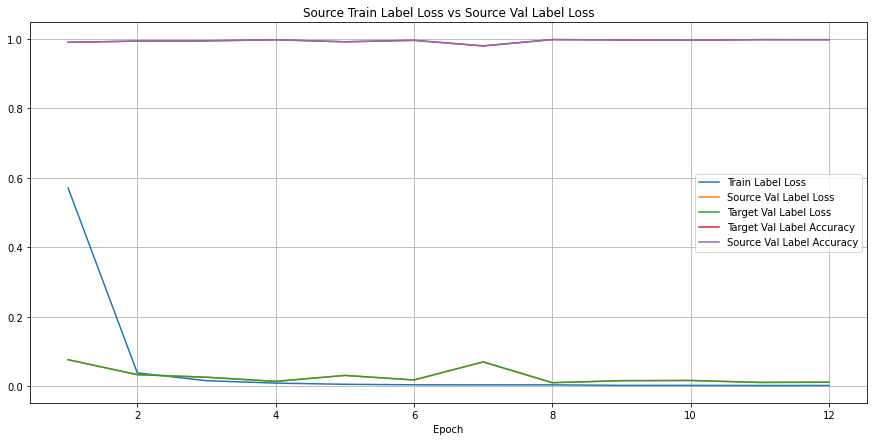

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

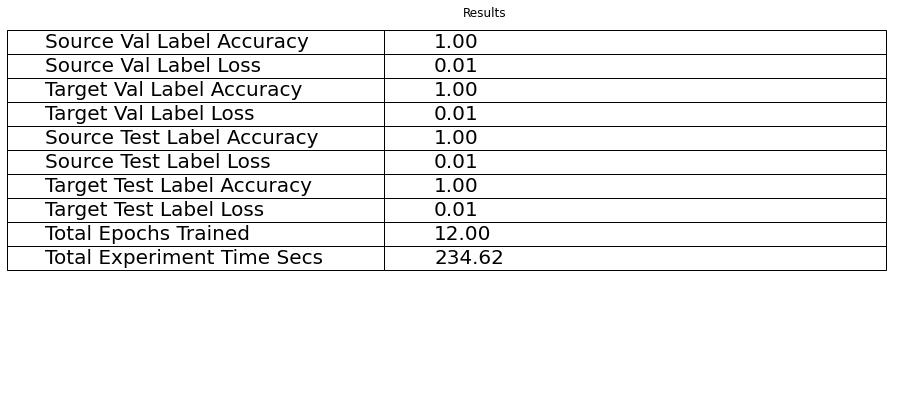

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

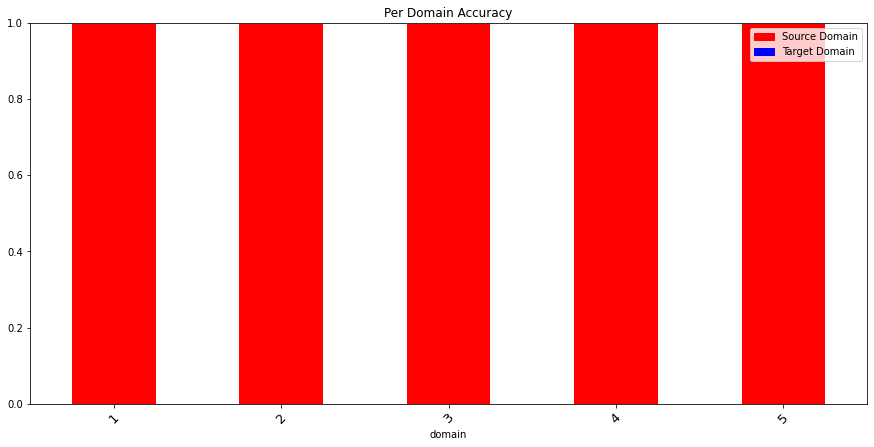

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9981253135479101 Target Test Label Accuracy: 0.9981253135479101
Source Val Label Accuracy: 0.9977308523986225 Target Val Label Accuracy: 0.9977308523986225


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:cores", "parameters": {"experiment_name": "cnn_2:cores", "device": "cuda", "lr": 0.0001, "labels": ["1-10.", "1-11.", "1-15.", "1-16.", "1-17.", "1-18.", "1-19.", "10-4.", "10-7.", "11-1.", "11-14.", "11-17.", "11-20.", "11-7.", "13-20.", "13-8.", "14-10.", "14-11.", "14-14.", "14-7.", "15-1.", "15-20.", "16-1.", "16-16.", "17-10.", "17-11.", "17-2.", "19-1.", "19-16.", "19-19.", "19-20.", "19-3.", "2-10.", "2-11.", "2-17.", "2-18.", "2-20.", "2-3.", "2-4.", "2-5.", "2-6.", "2-7.", "2-8.", "3-13.", "3-18.", "3-3.", "4-1.", "4-10.", "4-11.", "4-19.", "5-5.", "6-15.", "7-10.", "7-14.", "8-18.", "8-20.", "8-3.", "8-8."], "batch_size": 128, "domains_source": [1, 2, 3, 4, 5], "domains_target": [1, 2, 3, 4, 5], "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy